In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import json

# Read routes

In [ ]:
routes_path = "Paroutes/V2.1/loaded_routes.pickle" #adjust path
template_library_path = "Paroutes/Uspto-2.1/Templates-grouped/uspto_template_library.csv" #adjust path
unique_templates_path = "Paroutes/Uspto-2.1/uspto_unique_templates.csv.gz" #adjust path

save_folder = "data/uspto_routes/"
suffix = ""

with open(routes_path, "rb") as file:
    data = pickle.load(file)

# number of patents
print("number of patents", len(data))
# number of total routes
n_routes = sum([len(i) for i in data.values()])
print("number of routes in dataset: ", n_routes)

number of patents 66821
number of routes in dataset:  457166


# Create dictionaries to convert templates and reaction hashs

In [ ]:

template_library_general = pd.read_csv(
    template_library_path, sep="\t"
)

reaction2template_hash = {
    row["reaction_hash"]: row["template_hash"]
    for _, row in template_library_general.iterrows()
}
reaction2template_hash_general = {
    row["reaction_hash"]: row["template_hash_corr"]
    for _, row in template_library_general.iterrows()
}

template_hash2template_hash_general = {
    row["template_hash"]: row["template_hash_corr"]
    for _, row in template_library_general.iterrows()
}

template2template_general = {
    row["retro_template"]: row["retro_template_corr"]
    for _, row in template_library_general.iterrows()
}

template_hash2template_hash_general = {}

duplicates = []
for _, row in template_library_general.iterrows():
    key = row["template_hash"]
    if key not in template2template_general.keys():
        template_hash2template_hash_general[key] = row["template_hash_corr"]
    else:
        duplicates.append((row["template_hash"], row["template_hash_corr"]))

template_hash2template = {
    row["template_hash"]: row["retro_template"]
    for _, row in template_library_general.iterrows()
}

template_general_hash2template_general = {
    row["template_hash_corr"]: row["retro_template_corr"]
    for _, row in template_library_general.iterrows()
}

In [ ]:
print("Stats from reactions and templates")
print("number of unique reactions: ", len(template_library_general))
print(
    "number of unique templates: ", len(set(template_library_general["template_hash"]))
)
print(
    "number of unique r0_templates: ",
    len(set(template_library_general["template_hash_r0"])),
)
print(
    "number of unique corr_templates: ",
    len(set(template_library_general["template_hash_corr"])),
)

Stats from reactions and templates
number of unique reactions:  819789
number of unique templates:  42551
number of unique r0_templates:  13812
number of unique corr_templates:  20276


#  Create list with all routes containing all relevant template information

In [ ]:
# Creating all_routes that extracts all reaction_hashs from each route and converts to template_hash and template_hash_general

all_routes = []

all_patents = list(data.keys())
for patent in all_patents:
    routes = data[patent]
    for route in routes:
        hash_in_route = []
        hash_in_route_general, hash_in_route = [], []
        hashs = str(route).split("'reaction_hash': '")
        for hash in hashs[1:]:
            hash = hash.split("',")[0]
            hashs.append(hash)
            hash_in_route_general.append(reaction2template_hash_general[hash])
            hash_in_route.append(reaction2template_hash[hash])

        all_routes.append(
            {
                "route": route,
                "hash": hashs,
                "template_hash": hash_in_route,
                "template_hash_general": hash_in_route_general,
                "patent": patent,
            }
        )

# Plot the number of reaction templates and the number of routes

10000
5000
2000
1000
500
100


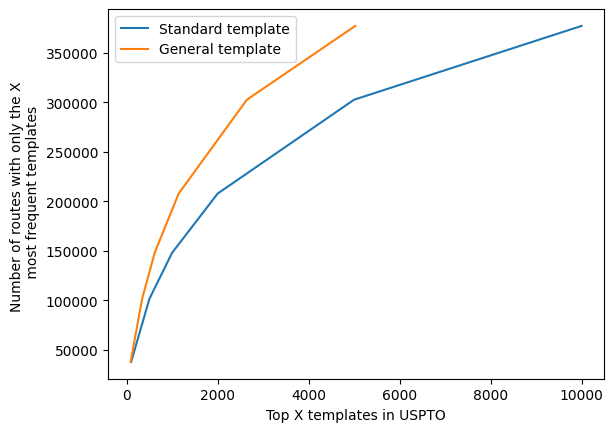

In [ ]:
# Filtering on the most frequently occuring templates

unique_templates = pd.read_csv(
    unique_templates_path,
    sep="\t",
)
top_n_templates = [10000, 5000, 2000, 1000, 500, 100]

n_routes_for_frequency = []
n_general_templates = []
for top_n in top_n_templates:
    print(top_n)
    filtered_routes = []
    filtered_templates = set(
        unique_templates.sort_values(by="library_occurence", ascending=False)[0:top_n][
            "template_hash"
        ].values
    )

    for route in all_routes:
        templates_in_route = set(route["template_hash"])
        if templates_in_route.issubset(filtered_templates):
            filtered_routes.append(route)

    n_routes_for_frequency.append(len(filtered_routes))

    filtered_templates_general = [
        template2template_general[template_hash2template[t]] for t in filtered_templates
    ]

    n_general_templates.append(len(set(filtered_templates_general)))

fig = plt.Figure()
fig = plt.plot(top_n_templates, n_routes_for_frequency, label="Standard template")
fig = plt.plot(n_general_templates, n_routes_for_frequency, label="General template")
plt.xlabel("Top X templates in USPTO")
plt.ylabel("Number of routes with only the X \n most frequent templates")
plt.legend()
plt.show()

# Filter the routes based on the most frequent reaction hashs

In [ ]:
unique_templates = pd.read_csv(
    unique_templates_path, sep="\t"
)
filtered_templates = unique_templates.sort_values(
    by="library_occurence", ascending=False
)

top_n = 1000
filtered_routes = []
n_routes_for_frequency = []
filtered_templates = set(
    unique_templates.sort_values(by="library_occurence", ascending=False)[0:top_n][
        "template_hash"
    ].values
)
print(len(filtered_templates))

for route in all_routes:
    templates_in_route = set(route["template_hash"])
    assert len(filtered_templates) == top_n
    assert len(templates_in_route) > 0
    if templates_in_route.issubset(filtered_templates):
        filtered_routes.append(route)

n_routes_for_frequency.append(len(filtered_routes))

filtered_templates_general = [
    template_hash2template_hash_general[t] for t in filtered_templates
]


print("number of routes", len(filtered_routes))
print("number of templates", len(set(filtered_templates)))
print("number of general templates", len(set(filtered_templates_general)))

1000
number of routes 148112
number of templates 1000
number of general templates 588


In [ ]:


filtered_templates_general = list(set(filtered_templates_general))
filtered_templates_smarts = [
    template_hash2template[hash] for hash in filtered_templates
]
filtered_templates_general_smarts = [
    template_general_hash2template_general[hash] for hash in filtered_templates_general
]

# save filtered_routes
save_routes = save_folder + f"uspto_routes_top{top_n}{suffix}.pickle"
with open(save_routes, "wb") as file:
    pickle.dump(filtered_routes, file)

# save filtered_templates_general_smarts
save_templates = save_folder + f"uspto_top{top_n}_general_templates_hash{suffix}.txt"
with open(save_templates, "w") as file:
    for item in filtered_templates_general:
        file.write(item)
        file.write("\n")

# save filtered_templates_general_smarts
save_templates = save_folder + f"uspto_top{top_n}_general_templates{suffix}.txt"
with open(save_templates, "w") as file:
    for item in filtered_templates_general_smarts:
        file.write(item)
        file.write("\n")

df_templates = pd.DataFrame(
    {"smiles": filtered_templates_general_smarts, "hash": filtered_templates_general}
)
save_templates = (
    save_folder + f"uspto_routes_top{top_n}_general_templates{suffix}.pickle"
)

df_templates.to_pickle(save_templates)

# Create building block file

In [ ]:
leaves = []
for route in filtered_routes:
    leaves.extend(route["route"]["leaves"])

print(len(leaves))
leaves = list(set(leaves))
print("Number of building blocks in all routes: ", len(leaves))

df_bb = pd.DataFrame({"inchi_key": leaves})
df_bb

391326
Number of building blocks in all routes:  38521


,inchi_key
0,KJXOBCYDQHCFIH-UHFFFAOYSA-N
1,TYMSKIYEAHPCAP-UHFFFAOYSA-N
2,DFOWMRQFRZJLNS-FQEVSTJZSA-N
3,IHXVDUQOHZEJLU-UHFFFAOYSA-N
4,YAZNOHYDAGXWLC-UHFFFAOYSA-N
...,...
38516,IQXCPFUERXPOCB-UHFFFAOYSA-N
38517,NXGSPDVKZCVBCA-UHFFFAOYSA-N
38518,LBXNUOBBOLWNBL-UHFFFAOYSA-N
38519,RYVZULLSFMHZHS-UHFFFAOYSA-N


In [ ]:
save_bb_path = save_folder + f"building_blocks_uspto_top{top_n}_templates{suffix}.csv"
df_bb.to_csv(save_bb_path)